In [4]:
!cp -r "/content/drive/MyDrive/data" "/content/data"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [5]:
!pip install split-folders

In [6]:
import splitfolders
splitfolders.ratio("/content/data", output="/content/dataset", seed=1337, ratio=(.8, .1, .1))

Copying files: 3998 files [00:13, 286.42 files/s]


In [7]:
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"
test_dir = "/content/dataset/test"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,

                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,

                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3198 files belonging to 2 classes.
Found 398 files belonging to 2 classes.
Found 402 files belonging to 2 classes.


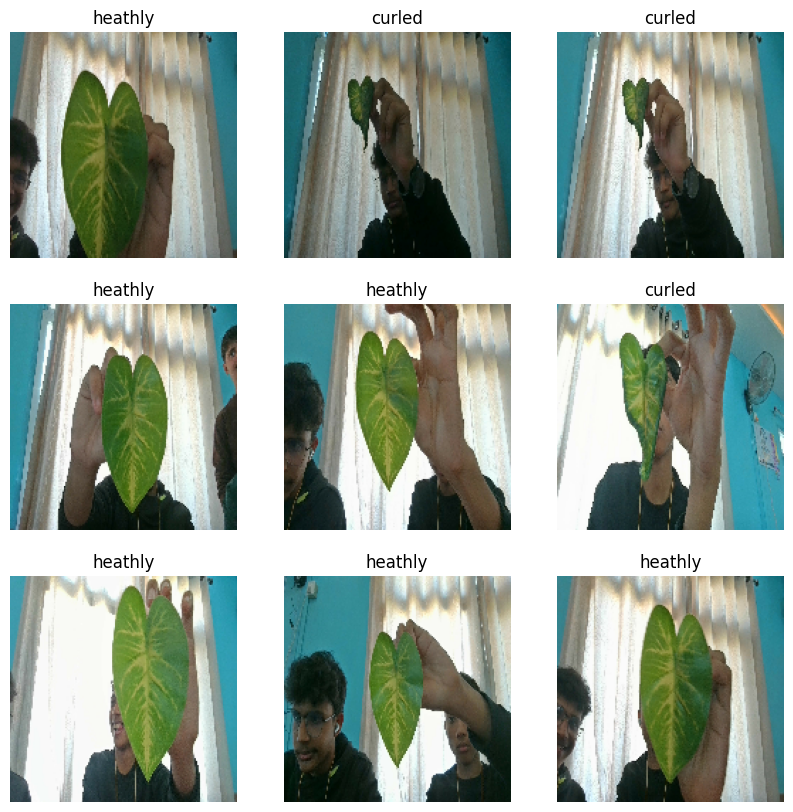

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 2


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB1(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [15]:
base_model.trainable = False

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.4400 - loss: 0.9808


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.95
initial accuracy: 0.47


In [22]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 292ms/step - accuracy: 0.5148 - loss: 0.7912 - val_accuracy: 0.5629 - val_loss: 0.6750
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 283ms/step - accuracy: 0.6837 - loss: 0.6006 - val_accuracy: 0.8234 - val_loss: 0.5394
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 279ms/step - accuracy: 0.7809 - loss: 0.5081 - val_accuracy: 0.9192 - val_loss: 0.4426
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.8148 - loss: 0.4474 - val_accuracy: 0.9371 - val_loss: 0.3805
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.8631 - loss: 0.3766 - val_accuracy: 0.9611 - val_loss: 0.3278
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 304ms/step - accuracy: 0.8769 - loss: 0.3466 - val_accuracy: 0.9671 - val_loss: 0.2884
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - accuracy: 0.8936 - loss: 0.3235 - val_accuracy: 0.9701 - val_loss: 0.2617
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.9035 - loss: 0

In [23]:
base_model.trainable = True

In [24]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  340


In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [26]:
len(model.trainable_variables)

215

In [27]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 342ms/step - accuracy: 0.7545 - loss: 0.5151 - val_accuracy: 0.9910 - val_loss: 0.1578
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 311ms/step - accuracy: 0.8984 - loss: 0.3298 - val_accuracy: 0.9940 - val_loss: 0.1257
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 310ms/step - accuracy: 0.9404 - loss: 0.2109 - val_accuracy: 1.0000 - val_loss: 0.0870
Epoch 14/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 311ms/step - accuracy: 0.9648 - loss: 0.1440 - val_accuracy: 0.9970 - val_loss: 0.0598
Epoch 15/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 310ms/step - accuracy: 0.9810 - loss: 0.0991 - val_accuracy: 1.0000 - val_loss: 0.0476
Epoch 16/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 310ms/step - accuracy: 0.9809 - loss: 0.0753 - val_accuracy: 1.0000 - val_loss: 0.0338
Epoch 17/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 327ms/step - accuracy: 0.9870 - loss: 0.0566 - val_accuracy: 1.0000 - val_loss: 0.0253
Epoch 18/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - accuracy: 0.9912 -

In [28]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 1.0000 - loss: 0.0127
Test accuracy : 1.0


Predictions:
 [0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1]
Labels:
 [0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1]


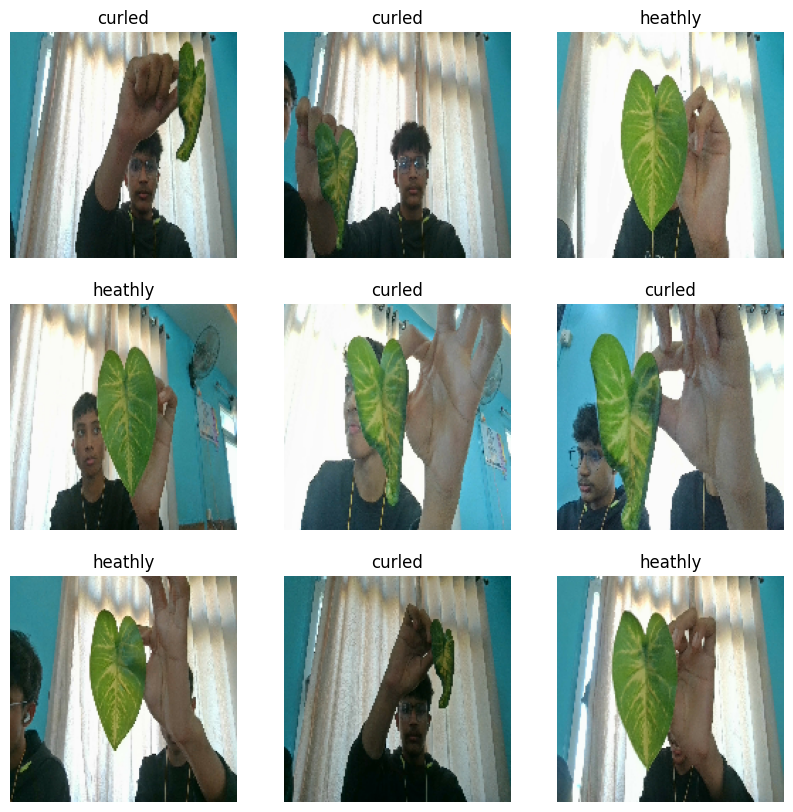

In [29]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


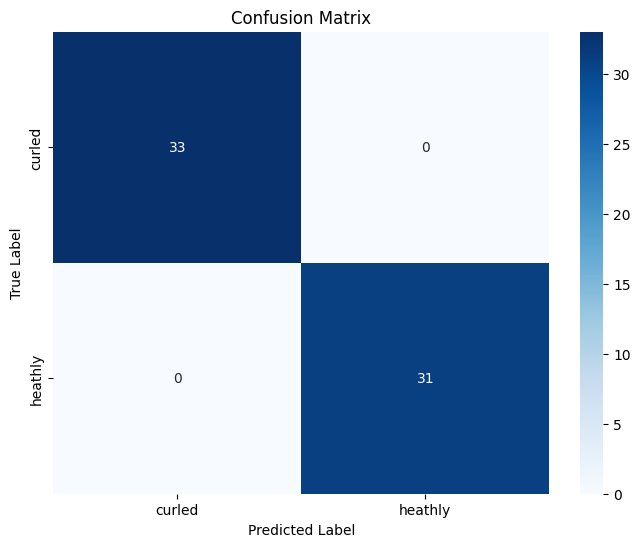

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1).numpy()
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
model.save("plant.keras")